In [361]:
#import dependencies 
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
from scipy.stats import linregress
#import scipy.stats as st

In [362]:
data_df=pd.read_csv("Data/HappinessAlcoholConsumption.csv")
data_df.head()

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,Denmark,Western Europe,north,7.526,928,53.579,224,81,278
1,Switzerland,Western Europe,north,7.509,943,79.866,185,100,280
2,Iceland,Western Europe,north,7.501,933,60.530,233,61,78
3,Norway,Western Europe,north,7.498,951,70.890,169,71,129
4,Finland,Western Europe,north,7.413,918,43.433,263,133,97


# Dataframe Information


In [363]:
data_df = data_df.dropna()

data_df.dtypes

Country              object
Region               object
Hemisphere           object
HappinessScore      float64
HDI                   int64
GDP_PerCapita       float64
Beer_PerCapita        int64
Spirit_PerCapita      int64
Wine_PerCapita        int64
dtype: object

In [364]:
for index, row in data_df.iterrows():
    if row["GDP_PerCapita"] % 1 > 0:
        data_df.loc[index, "GDP_PerCapita"] = 1000 * row["GDP_PerCapita"]
        
data_df.head()

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,Denmark,Western Europe,north,7.526,928,53579.0,224,81,278
1,Switzerland,Western Europe,north,7.509,943,79866.0,185,100,280
2,Iceland,Western Europe,north,7.501,933,60530.0,233,61,78
3,Norway,Western Europe,north,7.498,951,70890.0,169,71,129
4,Finland,Western Europe,north,7.413,918,43433.0,263,133,97


In [365]:
#shape of dataframe
data_df.shape

(122, 9)

In [366]:
#unique regions
data_df["Region"].unique()

array(['Western Europe', 'North America', 'Australia and New Zealand',
       'Middle East and Northern Africa', 'Latin America and Caribbean',
       'Southeastern Asia', 'Central and Eastern Europe', 'Eastern Asia',
       'Sub-Saharan Africa'], dtype=object)

In [367]:
#unique countries
data_df["Country"].unique()

array(['Denmark', 'Switzerland', 'Iceland', 'Norway', 'Finland', 'Canada',
       'Netherlands', 'New Zealand', 'Australia', 'Sweden', 'Israel',
       'Austria', 'United States', 'Costa Rica', 'Germany', 'Brazil',
       'Belgium', 'Ireland', 'Luxembourg', 'Mexico', 'Singapore',
       'United Kingdom', 'Chile', 'Panama', 'Argentina', 'Czech Republic',
       'United Arab Emirates', 'Uruguay', 'Malta', 'Colombia', 'France',
       'Thailand', 'Qatar', 'Spain', 'Guatemala', 'Suriname', 'Bahrain',
       'Trinidad and Tobago', 'Venezuela', 'Slovakia', 'El Salvador',
       'Nicaragua', 'Uzbekistan', 'Italy', 'Ecuador', 'Belize', 'Japan',
       'Kazakhstan', 'Moldova', 'Russian Federation', 'Poland',
       'South Korea', 'Bolivia', 'Lithuania', 'Belarus', 'Slovenia',
       'Peru', 'Turkmenistan', 'Mauritius', 'Latvia', 'Cyprus',
       'Paraguay', 'Romania', 'Estonia', 'Jamaica', 'Croatia', 'Turkey',
       'Jordan', 'Azerbaijan', 'Philippines', 'China', 'Kyrgyzstan',
       'Serbia',

In [368]:
data_df.columns

Index(['Country', 'Region', 'Hemisphere', 'HappinessScore', 'HDI',
       'GDP_PerCapita', 'Beer_PerCapita', 'Spirit_PerCapita',
       'Wine_PerCapita'],
      dtype='object')

# Importing Population Data
for use in averaging GDP per capita

In [369]:
pop_data = pd.read_csv("Data/Population Data/Global Population Trends(2016-2022).csv")
pop_data_2018 = pop_data.loc[pop_data["Year"] == 2018, ["Country", "Total Population"]]
pop_data_2018.head()

,Country,Total Population
1,Afghanistan,"36,686,784"
6,Albania,"2,866,376"
11,Algeria,"41,927,007"
15,American Samoa,"48,424"
19,Andorra,"75,013"


In [370]:
pop_data_2018["Total Population"]=pop_data_2018["Total Population"].str.replace(",","")
pop_data_2018["Total Population"] = pop_data_2018["Total Population"].astype("int")
pop_data_2018.dtypes

Country             object
Total Population     int64
dtype: object

For both datasets, I looked to see which countries showed up in both datasets, but with different names, e.g. "Republic of Congo" in one set was called "Rep. Congo" in the other. I updated the naming to be consistent in both files to ensure the inner join below would guarantee the maximum number of countries upon joining.

In [371]:
merged_data = pd.merge(pop_data_2018, data_df, how = "inner", left_on = "Country", right_on = "Country")
merged_data

,Country,Total Population,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,Albania,2866376,Central and Eastern Europe,north,4.655,782,4132.0,89,132,54
1,Angola,31273533,Sub-Saharan Africa,south,3.866,577,3309.0,217,57,45
2,Argentina,44494502,Latin America and Caribbean,south,6.650,822,12654.0,193,25,221
3,Armenia,2836557,Central and Eastern Europe,north,4.360,749,3606.0,21,179,11
4,Australia,24966643,Australia and New Zealand,south,7.313,938,49897.0,261,72,212
...,...,...,...,...,...,...,...,...,...,...
106,Uzbekistan,32956100,Central and Eastern Europe,north,5.987,703,2106.0,25,101,8
107,Venezuela,29825653,Latin America and Caribbean,north,6.084,766,15692.0,333,100,3
108,Vietnam,94914330,Southeastern Asia,north,5.061,689,2171.0,111,2,1
109,Zambia,17835893,Sub-Saharan Africa,south,4.795,586,1263.0,32,19,4


In [372]:
merged_data.dtypes

Country              object
Total Population      int64
Region               object
Hemisphere           object
HappinessScore      float64
HDI                   int64
GDP_PerCapita       float64
Beer_PerCapita        int64
Spirit_PerCapita      int64
Wine_PerCapita        int64
dtype: object

In [373]:
merged_data_complete = merged_data.copy()

merged_data_complete["GDP"] = merged_data_complete["Total Population"] * merged_data_complete["GDP_PerCapita"]
merged_data_complete["Beer"] = merged_data_complete["Total Population"] * merged_data_complete["Beer_PerCapita"]
merged_data_complete["Spirit"] = merged_data_complete["Total Population"] * merged_data_complete["Spirit_PerCapita"]
merged_data_complete["Wine"] = merged_data_complete["Total Population"] * merged_data_complete["Wine_PerCapita"]

merged_data_complete

,Country,Total Population,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita,GDP,Beer,Spirit,Wine
0,Albania,2866376,Central and Eastern Europe,north,4.655,782,4132.0,89,132,54,1.184387e+10,255107464,378361632,154784304
1,Angola,31273533,Sub-Saharan Africa,south,3.866,577,3309.0,217,57,45,1.034841e+11,6786356661,1782591381,1407308985
2,Argentina,44494502,Latin America and Caribbean,south,6.650,822,12654.0,193,25,221,5.630334e+11,8587438886,1112362550,9833284942
3,Armenia,2836557,Central and Eastern Europe,north,4.360,749,3606.0,21,179,11,1.022862e+10,59567697,507743703,31202127
4,Australia,24966643,Australia and New Zealand,south,7.313,938,49897.0,261,72,212,1.245761e+12,6516293823,1797598296,5292928316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,Uzbekistan,32956100,Central and Eastern Europe,north,5.987,703,2106.0,25,101,8,6.940555e+10,823902500,3328566100,263648800
107,Venezuela,29825653,Latin America and Caribbean,north,6.084,766,15692.0,333,100,3,4.680241e+11,9931942449,2982565300,89476959
108,Vietnam,94914330,Southeastern Asia,north,5.061,689,2171.0,111,2,1,2.060590e+11,10535490630,189828660,94914330
109,Zambia,17835893,Sub-Saharan Africa,south,4.795,586,1263.0,32,19,4,2.252673e+10,570748576,338881967,71343572


In [374]:
region_data = merged_data_complete.groupby(["Region"])
per_capita_data = region_data[["Total Population", "GDP","Beer", "Spirit", "Wine"]].sum()

per_capita_data["GDP_per"] = per_capita_data["GDP"] / per_capita_data["Total Population"]
per_capita_data["Beer_per"] = per_capita_data["Beer"] / per_capita_data["Total Population"]
per_capita_data["Spirit_per"] = per_capita_data["Spirit"] / per_capita_data["Total Population"]
per_capita_data["Wine_per"] = per_capita_data["Wine"] / per_capita_data["Total Population"]

per_capita_data

,Total Population,GDP,Beer,Spirit,Wine,GDP_per,Beer_per,Spirit_per,Wine_per
Region,,,,,,,,,
Australia and New Zealand,29867243,1.443412e+12,7511115623,2184745696,6150533316,48327.580318,251.483393,73.148556,205.929061
Central and Eastern Europe,238131888,1.735487e+12,46601128108,43702128613,16124653986,7287.924368,195.694615,183.520691,67.713124
Eastern Asia,1584320049,1.773818e+13,128048022427,296369097227,13740633450,11196.085035,80.822068,187.063906,8.672890
Latin America and Caribbean,620935842,5.198035e+12,128317469408,66590072205,19663165982,8371.290865,206.651736,107.241470,31.666985
Middle East and Northern Africa,263958197,2.035446e+12,6692061699,3857903611,1586001401,7711.243234,25.352733,14.615586,6.008532
North America,363903283,2.039195e+13,90278331711,56162375690,31160917116,56036.741731,248.083312,154.333248,85.629667
Southeastern Asia,296274882,1.283568e+12,26537289510,39843909654,352661642,4332.355802,89.569826,134.482915,1.190319
Sub-Saharan Africa,665006650,1.235485e+12,44281528094,11331151195,8157507986,1857.852876,66.588098,17.039155,12.266807
Western Europe,425101959,1.638097e+13,92604106786,47085065775,93387973863,38534.225105,217.839755,110.761818,219.683706


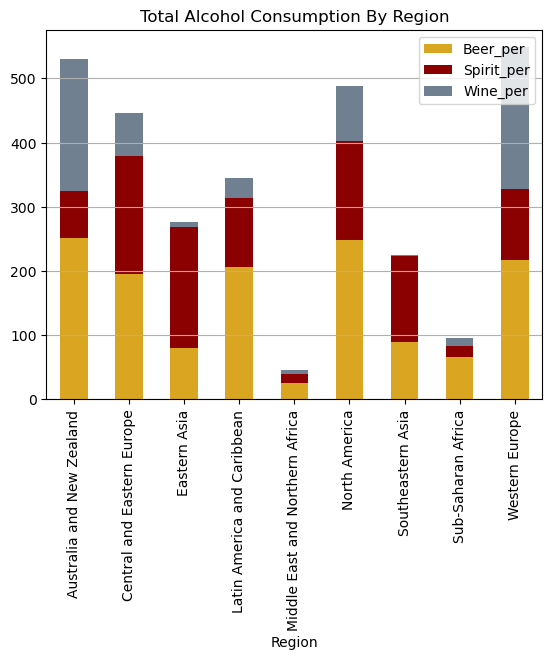

In [375]:
per_capita_data_copy = per_capita_data.copy()

per_capita_data_copy = per_capita_data_copy.reset_index()

per_capita_data_copy[["Region", "Beer_per", "Spirit_per", "Wine_per"]]\
    .plot.bar(x = "Region",
              stacked = True,
              title = "Total Alcohol Consumption By Region",
              color = ["goldenrod", "darkred", "slategray"]
             )
plt.grid(axis = "y")
# per_capita_data_copy.plot(x = "Region", y = "Wine_per", kind = "bar")
# per_capita_data_copy.plot(x = "Region", y = "Spirit_per", kind = "bar")

plt.show()

# GDP Analysis
first by regional averages, then by country

In [376]:
#Analysing GDP
gdp_df=merged_data_complete[["Country","Region","GDP","Hemisphere","HappinessScore"]].copy()
gdp_df

,Country,Region,GDP,Hemisphere,HappinessScore
0,Albania,Central and Eastern Europe,1.184387e+10,north,4.655
1,Angola,Sub-Saharan Africa,1.034841e+11,south,3.866
2,Argentina,Latin America and Caribbean,5.630334e+11,south,6.650
3,Armenia,Central and Eastern Europe,1.022862e+10,north,4.360
4,Australia,Australia and New Zealand,1.245761e+12,south,7.313
...,...,...,...,...,...
106,Uzbekistan,Central and Eastern Europe,6.940555e+10,north,5.987
107,Venezuela,Latin America and Caribbean,4.680241e+11,north,6.084
108,Vietnam,Southeastern Asia,2.060590e+11,north,5.061
109,Zambia,Sub-Saharan Africa,2.252673e+10,south,4.795


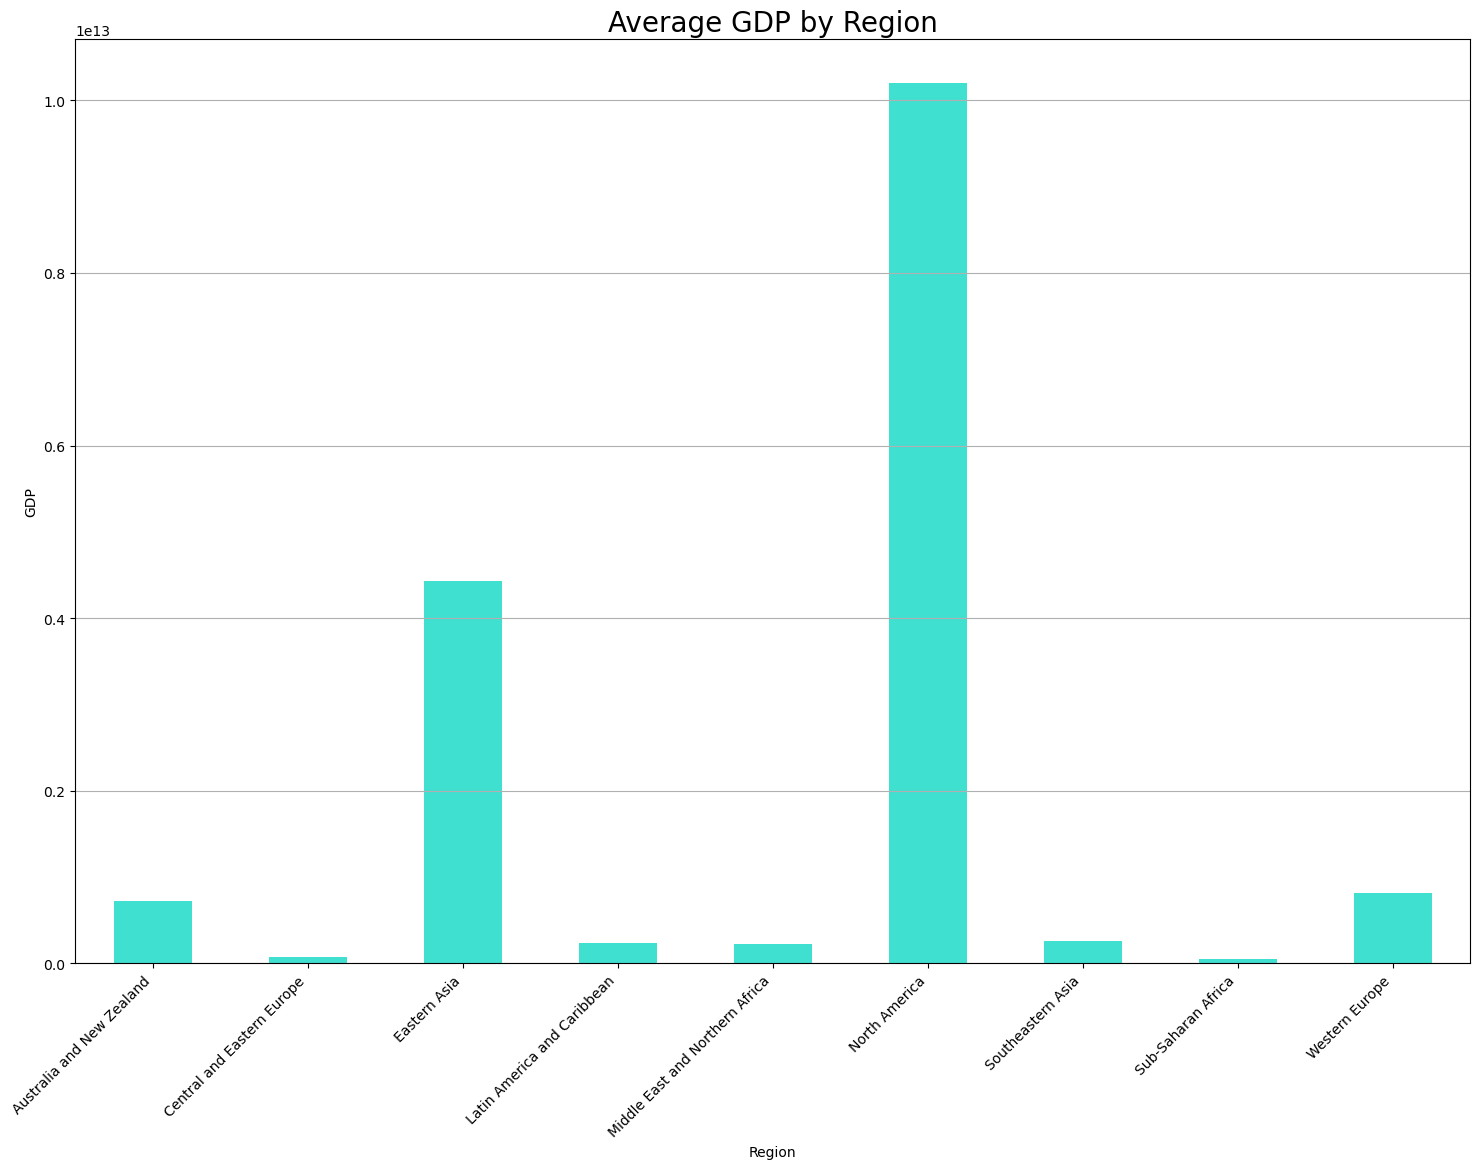

In [377]:
#Average GDP by Region
plt.figure(figsize=(18,12))
gdp_df.groupby('Region')['GDP'].mean().plot(kind='bar', color='turquoise')
plt.title('Average GDP by Region', fontsize=20)
plt.xlabel('Region')
plt.ylabel('GDP')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis = "y")

#save figure
plt.savefig("output_data/GDP_HDI/Average_GDP_by_Region.png", bbox_inches='tight')

plt.show()

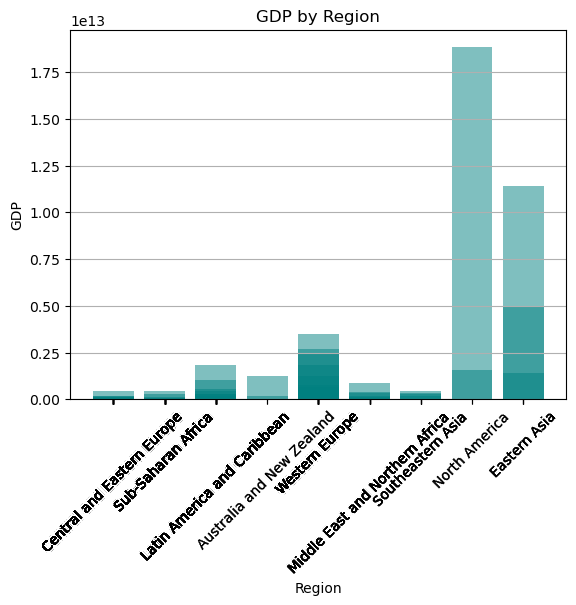

In [378]:
#chart for GDP by Region
gdp=gdp_df["GDP"]
region=gdp_df["Region"]

plt.bar(region,gdp,color="teal",alpha=0.5,align="center")
tick_loactions=[value for value in region]
plt.xticks(tick_loactions,region,rotation=45)
plt.grid(axis = "y")


plt.title("GDP by Region")
plt.xlabel("Region")
plt.ylabel("GDP")

plt.savefig("output_data/GDP_HDI/GDP_by_Region.png", bbox_inches='tight')

plt.show()

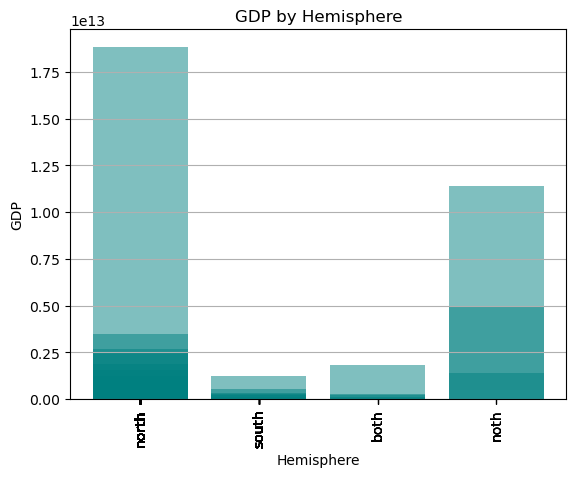

In [379]:
#chart for GDP by Hemisphere
gdp=gdp_df["GDP"]
region=gdp_df["Hemisphere"]

plt.bar(region,gdp,color="teal",alpha=0.5,align="center")
tick_loactions=[value for value in region]
plt.xticks(tick_loactions,region,rotation=90)
plt.grid(axis = "y")


plt.title("GDP by Hemisphere")
plt.xlabel("Hemisphere")
plt.ylabel("GDP")

plt.savefig("output_data/GDP_HDI/GDP_by_hemisphere.png", bbox_inches='tight')

plt.show()

In [380]:
#top 20 GDP countries
gdp=gdp_df.sort_values(["GDP"],ascending=False)
gdp.head(25)

,Country,Region,GDP,Hemisphere,HappinessScore
104,United States,North America,1.882229e+13,north,7.104
22,China,Eastern Asia,1.138620e+13,noth,5.245
51,Japan,Eastern Asia,4.942078e+12,noth,5.921
39,Germany,Western Europe,3.501360e+12,north,6.994
103,United Kingdom,Western Europe,2.685795e+12,north,6.725
36,France,Western Europe,2.476128e+12,north,6.478
49,Italy,Western Europe,1.853075e+12,north,5.977
14,Brazil,Latin America and Caribbean,1.815629e+12,both,6.952
19,Canada,North America,1.569669e+12,north,7.404
91,South Korea,Eastern Asia,1.398213e+12,noth,5.835


<Figure size 1500x1000 with 0 Axes>

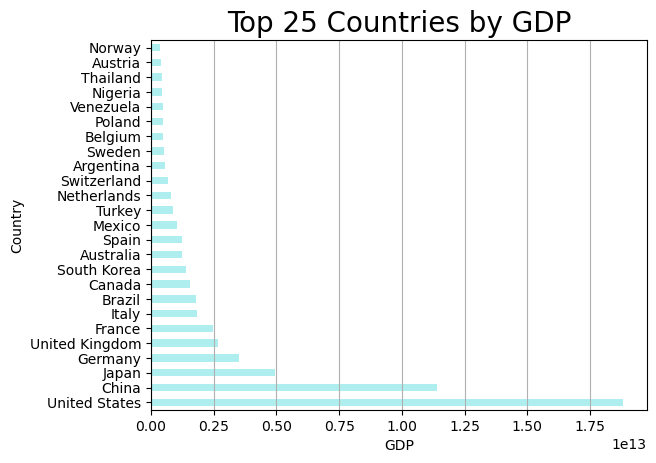

In [381]:
#chart top 25 countries by GDP
gdp=gdp_df["GDP"]
country=gdp_df["Country"]

plt.figure(figsize=(15, 10))
top_25_countries = gdp_df.nlargest(25, 'GDP')
top_25_countries.plot(kind='barh', x='Country', y='GDP', color='paleturquoise', legend=False)
plt.title('Top 25 Countries by GDP', fontsize=20)
plt.xlabel('GDP')
plt.ylabel('Country')
plt.grid(axis = "x")


plt.savefig("output_data/GDP_HDI/Top_GDP.png", bbox_inches='tight')
plt.show()


In [382]:
#bottom 20 GDP countries
gdp=gdp_df.sort_values(["GDP"],ascending=True)
gdp.head(25)

,Country,Region,GDP,Hemisphere,HappinessScore
24,Comoros,Sub-Saharan Africa,6.016426e+08,south,3.956
10,Belize,Latin America and Caribbean,1.895047e+09,north,5.956
57,Liberia,Sub-Saharan Africa,2.224673e+09,north,3.622
93,Suriname,Latin America and Caribbean,3.485701e+09,north,6.269
87,Sierra Leone,Sub-Saharan Africa,3.781276e+09,north,4.635
68,Montenegro,Central and Eastern Europe,4.373634e+09,north,5.161
98,Togo,Sub-Saharan Africa,4.642934e+09,north,3.303
66,Moldova,Central and Eastern Europe,5.178879e+09,north,5.897
61,Malawi,Sub-Saharan Africa,5.510365e+09,south,4.156
43,Haiti,Latin America and Caribbean,8.094129e+09,north,4.028


<Figure size 1500x1000 with 0 Axes>

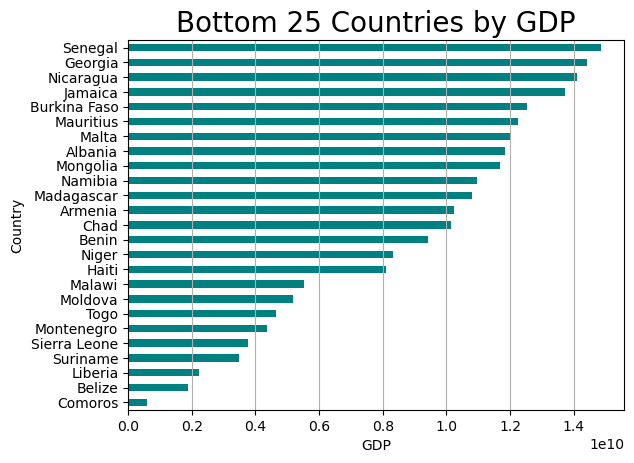

In [383]:
#Bottom 25 countries by GDP
plt.figure(figsize=(15, 10))
smallest_25_countries = gdp_df.nsmallest(25, 'GDP')
smallest_25_countries.plot(kind='barh', x='Country', y='GDP', color='teal', legend=False)
plt.title('Bottom 25 Countries by GDP', fontsize=20)
plt.xlabel('GDP')
plt.ylabel('Country')
plt.grid(axis = "x")


plt.savefig("output_data/GDP_HDI/Bottom_GDP.png", bbox_inches='tight')
plt.show()

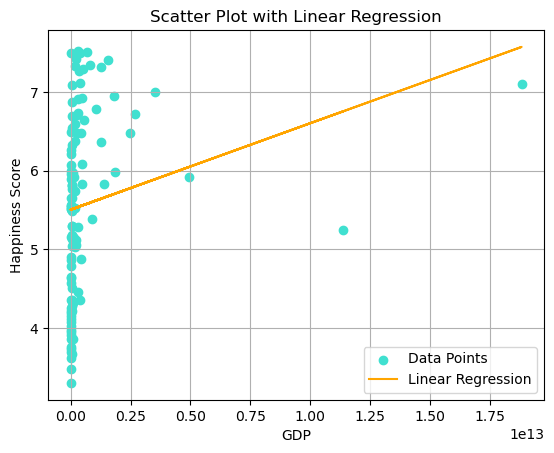

In [384]:
#GDP V Happiness
plt.scatter(gdp_df["GDP"], gdp_df["HappinessScore"], color="turquoise", label="Data Points")

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(gdp_df["GDP"], gdp_df["HappinessScore"])

# Plot the regression line
regression_line = slope * gdp_df["GDP"] + intercept
plt.plot(gdp_df["GDP"], regression_line, color="orange", label="Linear Regression")
# Customize the plot
plt.title("Scatter Plot with Linear Regression")
plt.xlabel("GDP")
plt.ylabel("Happiness Score")
plt.legend()
plt.grid()

plt.savefig("output_data/GDP_HDI/HappyGDP.png", bbox_inches='tight')
plt.show()

# Human Deveolpment Index (HDI)
first by regional averages, then by country

In [385]:
#Analysing for HDI by Region
hdi_df=data_df[["Country","Region","HDI","Hemisphere","HappinessScore"]].copy()
hdi_df

,Country,Region,HDI,Hemisphere,HappinessScore
0,Denmark,Western Europe,928,north,7.526
1,Switzerland,Western Europe,943,north,7.509
2,Iceland,Western Europe,933,north,7.501
3,Norway,Western Europe,951,north,7.498
4,Finland,Western Europe,918,north,7.413
...,...,...,...,...,...
117,Tanzania,Sub-Saharan Africa,533,south,3.666
118,Liberia,Sub-Saharan Africa,432,north,3.622
119,Benin,Sub-Saharan Africa,512,north,3.484
120,Togo,Sub-Saharan Africa,500,north,3.303


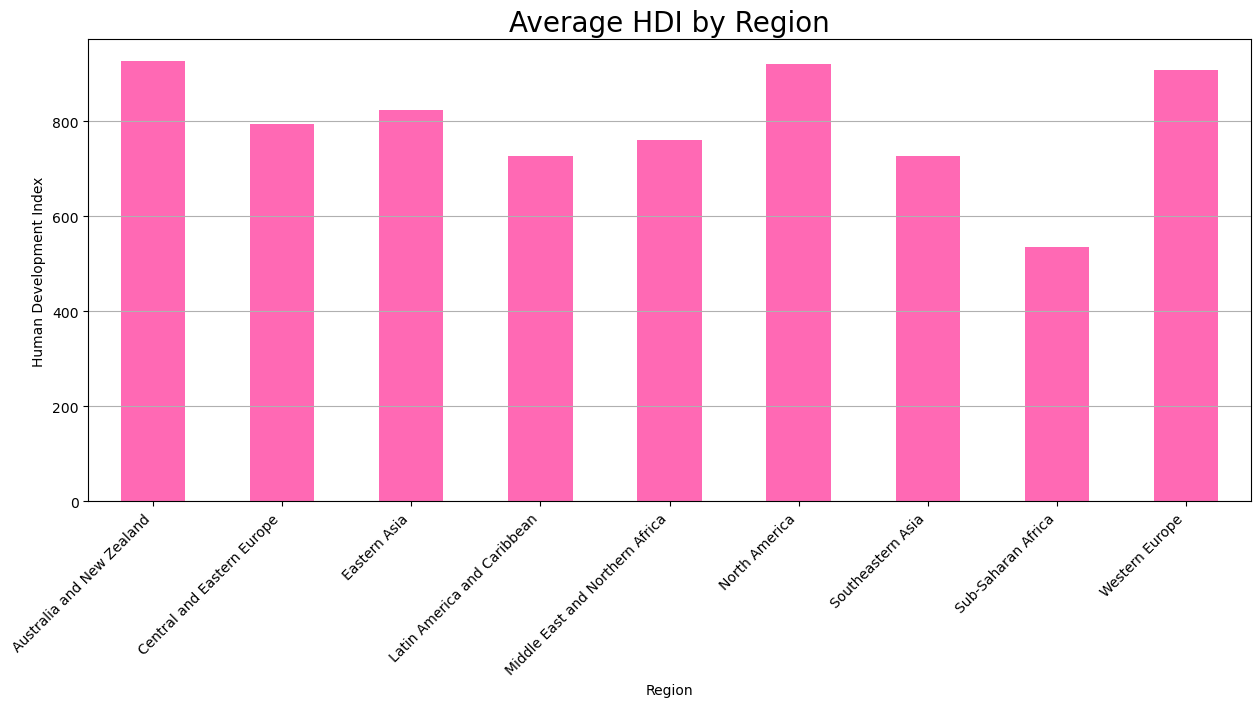

In [386]:
#average HDI per region
plt.figure(figsize=(15, 6))
hdi_df.groupby('Region')['HDI'].mean().plot(kind='bar', color='hotpink')
plt.title('Average HDI by Region', fontsize=20)
plt.xlabel('Region')
plt.ylabel('Human Development Index')
plt.xticks(rotation=45, ha='right')
plt.grid(axis = "y")


plt.savefig("output_data/GDP_HDI/Average_HDI_by_Region.png", bbox_inches='tight')
plt.show()

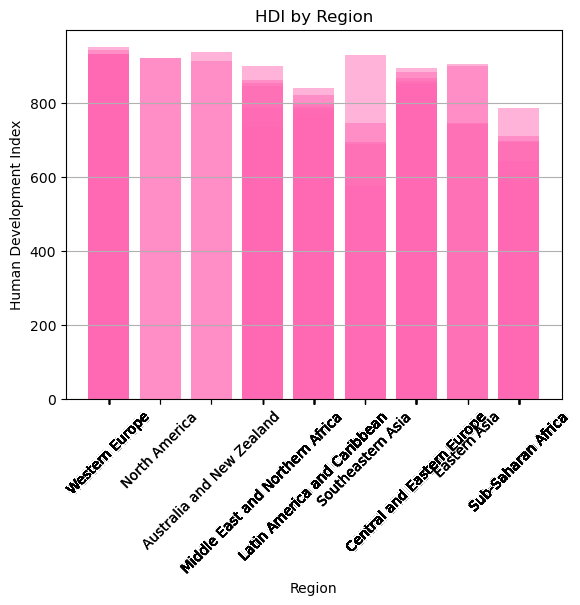

In [387]:
#HDI per region
hdi=hdi_df["HDI"]
region=hdi_df["Region"]

plt.bar(region,hdi,color="hotpink",alpha=0.5,align="center")
tick_loactions=[value for value in region]
plt.xticks(tick_loactions,region,rotation=45)
plt.grid(axis = "y")


plt.title("HDI by Region")
plt.xlabel("Region")
plt.ylabel("Human Development Index")

plt.savefig("output_data/GDP_HDI/HDI_by_Region.png", bbox_inches='tight')
plt.show()

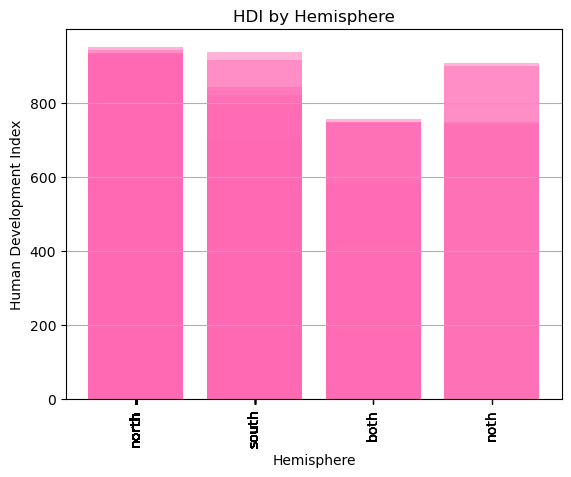

In [388]:
#chart for HDI by Hemisphere
hdi=hdi_df["HDI"]
region=hdi_df["Hemisphere"]

plt.bar(region,hdi,color="hotpink",alpha=0.5,align="center")
tick_loactions=[value for value in region]
plt.xticks(tick_loactions,region,rotation=90)
plt.grid(axis = "y")


plt.title("HDI by Hemisphere")
plt.xlabel("Hemisphere")
plt.ylabel("Human Development Index")

plt.savefig("output_data/GDP_HDI/HDI_by_Hemisphere.png", bbox_inches='tight')
plt.show()

In [389]:
#Top 25 HDI Countries
hdi=hdi_df.sort_values(["HDI"],ascending=False)
hdi.head(25)

,Country,Region,HDI,Hemisphere,HappinessScore
3,Norway,Western Europe,951,north,7.498
1,Switzerland,Western Europe,943,north,7.509
8,Australia,Australia and New Zealand,938,south,7.313
14,Germany,Western Europe,934,north,6.994
17,Ireland,Western Europe,934,north,6.907
2,Iceland,Western Europe,933,north,7.501
9,Sweden,Western Europe,932,north,7.291
20,Singapore,Southeastern Asia,930,north,6.739
0,Denmark,Western Europe,928,north,7.526
6,Netherlands,Western Europe,928,north,7.339


<Figure size 1500x1000 with 0 Axes>

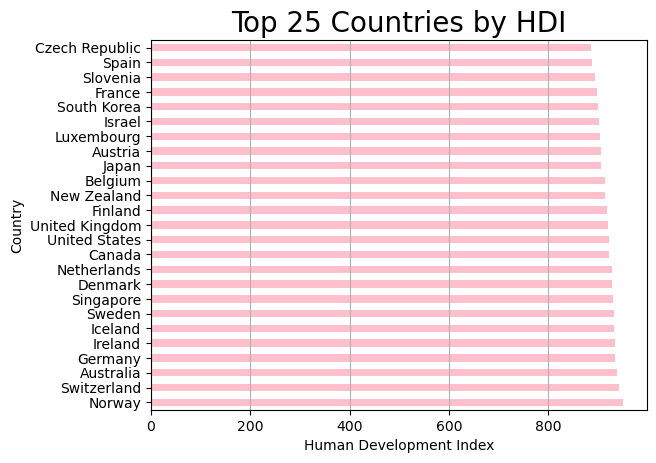

In [390]:
#Top 25 HDI Countries Graph
hdi=hdi_df["HDI"]
country=hdi_df["Country"]

plt.figure(figsize=(15, 10))
top_25_countries = hdi_df.nlargest(25, 'HDI')
top_25_countries.plot(kind='barh', x='Country', y='HDI', color='pink', legend=False)
plt.title('Top 25 Countries by HDI', fontsize=20)
plt.xlabel('Human Development Index')
plt.ylabel('Country')
plt.grid(axis = "x")


plt.savefig("output_data/GDP_HDI/Top_HDI.png", bbox_inches='tight')
plt.show()

In [391]:
#bottom 25 HDI Countries
hdi=hdi_df.sort_values(["HDI"],ascending=True)
hdi.head(25)

,Country,Region,HDI,Hemisphere,HappinessScore
113,Niger,Sub-Saharan Africa,351,north,3.856
114,Chad,Sub-Saharan Africa,405,north,3.763
89,Sierra Leone,Sub-Saharan Africa,413,north,4.635
115,Burkina Faso,Sub-Saharan Africa,420,north,3.739
106,Mali,Sub-Saharan Africa,421,north,4.073
118,Liberia,Sub-Saharan Africa,432,north,3.622
98,Dem. Rep. Congo,Sub-Saharan Africa,452,south,4.272
104,Malawi,Sub-Saharan Africa,474,south,4.156
110,Cote d'Ivoire,Sub-Saharan Africa,486,north,3.916
107,Haiti,Latin America and Caribbean,496,north,4.028


<Figure size 1500x1000 with 0 Axes>

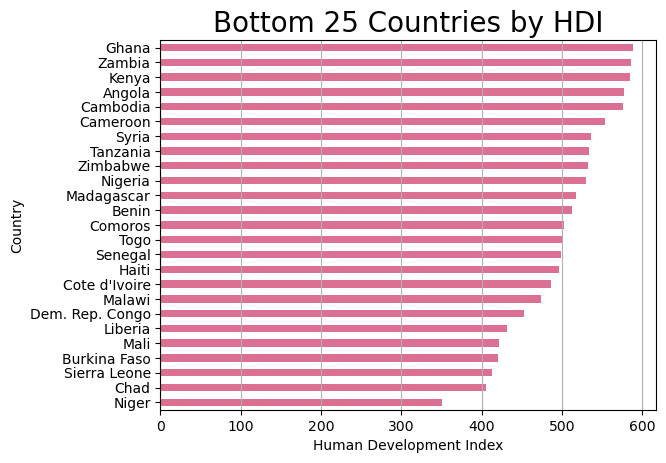

In [392]:
#bottom 25 HDI Countries
hdi=hdi_df["HDI"]
country=hdi_df["Country"]

plt.figure(figsize=(15, 10))
top_25_countries = hdi_df.nsmallest(25, 'HDI')
top_25_countries.plot(kind='barh', x='Country', y='HDI', color='palevioletred', legend=False)
plt.title('Bottom 25 Countries by HDI', fontsize=20)
plt.xlabel('Human Development Index')
plt.ylabel('Country')
plt.grid(axis = "x")



plt.savefig("output_data/GDP_HDI/Bottom_HDI.png", bbox_inches='tight')
plt.show()

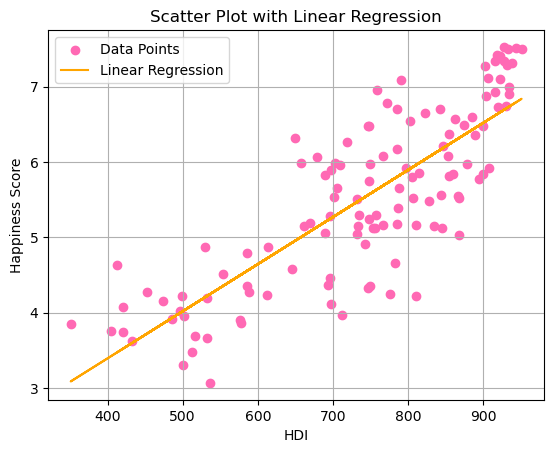

In [393]:
#HDI V Happiness
plt.scatter(hdi_df["HDI"], hdi_df["HappinessScore"], color="hotpink", label="Data Points")
# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(hdi_df["HDI"], hdi_df["HappinessScore"])

# Plot the regression line
regression_line = slope * hdi_df["HDI"] + intercept
plt.plot(hdi_df["HDI"], regression_line, color="orange", label="Linear Regression")

# Customize the plot
plt.title("Scatter Plot with Linear Regression")
plt.xlabel("HDI")
plt.ylabel("Happiness Score")
plt.legend()
plt.grid()

plt.savefig("output_data/GDP_HDI/HappyHDI.png", bbox_inches='tight')
plt.show()

## Happy Places

In [394]:
#Happy Places
#Happiest places (Top 10)
most_happiest_df = data_df.head(10)
most_happiest_df = most_happiest_df [["Country","HappinessScore"]]
most_happiest_df

,Country,HappinessScore
0,Denmark,7.526
1,Switzerland,7.509
2,Iceland,7.501
3,Norway,7.498
4,Finland,7.413
5,Canada,7.404
6,Netherlands,7.339
7,New Zealand,7.334
8,Australia,7.313
9,Sweden,7.291


In [395]:
least_happiest_df = data_df.tail(10)
least_happiest_df= least_happiest_df [["Country","HappinessScore"]]
least_happiest_df

,Country,HappinessScore
112,Angola,3.866
113,Niger,3.856
114,Chad,3.763
115,Burkina Faso,3.739
116,Madagascar,3.695
117,Tanzania,3.666
118,Liberia,3.622
119,Benin,3.484
120,Togo,3.303
121,Syria,3.069


In [396]:
#Happies Regions (Top 10)HappinessScore
happy_region_df = data_df.groupby(["Region"])["HappinessScore"].mean()
happy_region_df 

Region
Australia and New Zealand          7.323500
Central and Eastern Europe         5.383444
Eastern Asia                       5.477000
Latin America and Caribbean        6.061000
Middle East and Northern Africa    5.443727
North America                      7.254000
Southeastern Asia                  5.492000
Sub-Saharan Africa                 4.151464
Western Europe                     6.731400
Name: HappinessScore, dtype: float64

In [397]:
#Happies Hemisphere
happy_hemisphere_df = data_df.groupby(["Hemisphere"])["HappinessScore"].mean()
happy_hemisphere_df 

Hemisphere
both     5.901600
north    5.632935
noth     5.477000
south    4.970619
Name: HappinessScore, dtype: float64

Text(0, 0.5, 'Happiness Score')

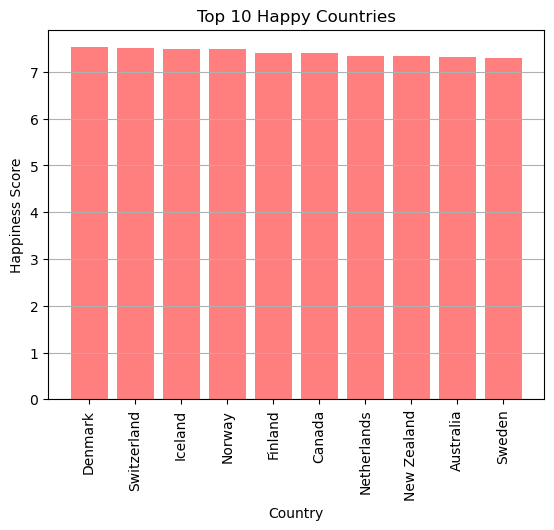

In [398]:
#Happiness Level Visualization
#Most top 10 happy country
happy=most_happiest_df["HappinessScore"]
country=most_happiest_df["Country"]

plt.bar(country,happy,color="r",alpha=0.5,align="center")
tick_loactions=[value for value in country]
plt.xticks(tick_loactions,country,rotation=90)
plt.grid(axis = "y")


plt.title("Top 10 Happy Countries")
plt.xlabel("Country")
plt.ylabel("Happiness Score")

Text(0, 0.5, 'Happiness Score')

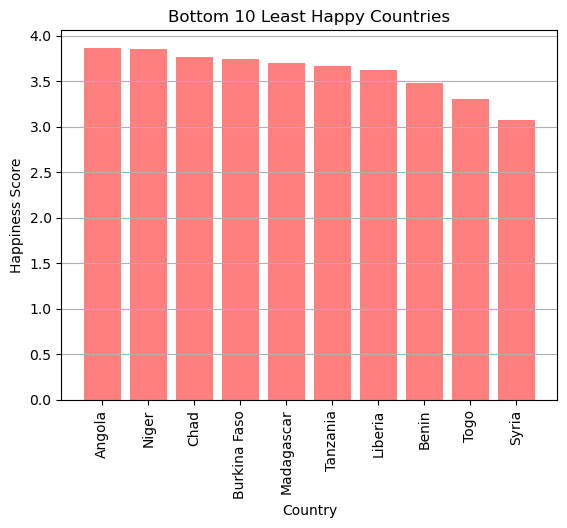

In [399]:
#Happiness Level Visualization
#Bottow 10 least happy country
happy=least_happiest_df["HappinessScore"]
country=least_happiest_df["Country"]

plt.bar(country,happy,color="r",alpha=0.5,align="center")
tick_loactions=[value for value in country]
plt.xticks(tick_loactions,country,rotation=90)
plt.grid(axis = "y")


plt.title("Bottom 10 Least Happy Countries")
plt.xlabel("Country")
plt.ylabel("Happiness Score")

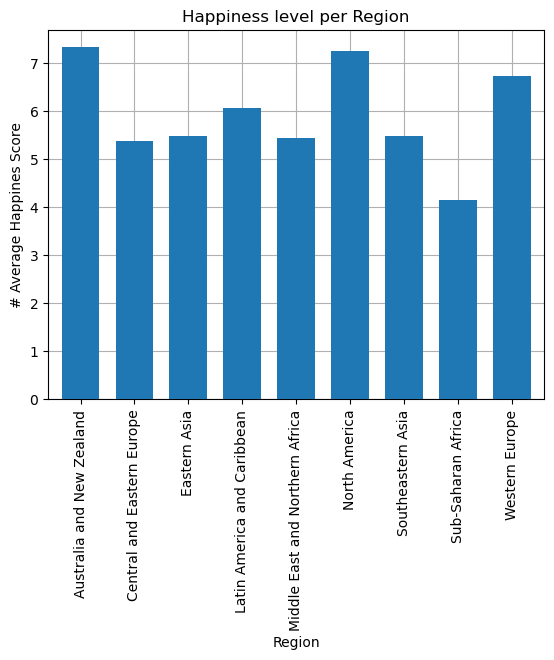

In [400]:
#Happiness level per Region

bar_plot = happy_region_df.plot.bar(width=0.7, zorder=3)

# Set labels for axes
bar_plot.set_xlabel("Region")
bar_plot.set_ylabel("# Average Happines Score")
bar_plot.set_title("Happiness level per Region")


# Create a grid - using 'zorder' places grid behind the bars since we set their z-order higher
bar_plot.grid(zorder=0)

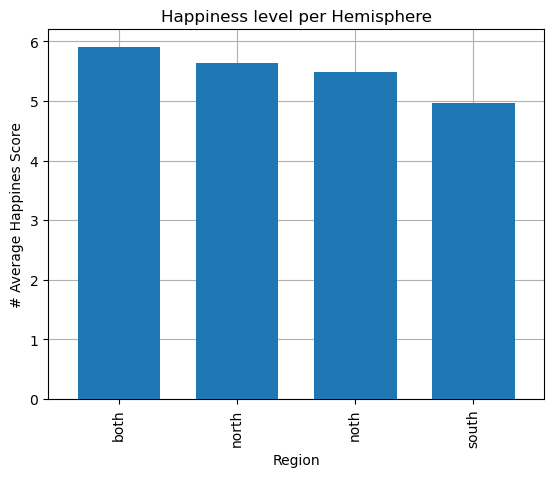

In [401]:
#Happiness level per Hemisphere\n",
bar_plot = happy_hemisphere_df.plot.bar(width=0.7, zorder=3)
# Set labels for axes\n",
bar_plot.set_xlabel("Region")
bar_plot.set_ylabel("# Average Happines Score")
bar_plot.set_title("Happiness level per Hemisphere")
# Create a grid - using 'zorder' places grid behind the bars since we set their z-order higher\n"
bar_plot.grid(zorder=0)

## Alcohol Consumption and Happiness

In [402]:
OH_happiness = merged_data_complete[["Country", "HappinessScore", "Beer_PerCapita", "Spirit_PerCapita", "Wine_PerCapita"]].copy()
len(OH_happiness)

111

In [403]:
# function to create create scatter and linear regression plots
def lin_regress(x_vals, y_vals, color, x_ann, y_ann):
    (slope, intercept, rval, pval, stderr) = linregress(x_vals, y_vals)
    #plt.subplots(figsize=(15, 6))
    print(f"The {x_vals.name} r-value is: {rval}")
    regress_vals = x_vals * slope + intercept
    line_eq = f"y = {round(slope,5)} x + {round(intercept,2)}"
    #title = f"Happiness by {x_label}"
    plt.scatter(x_vals, y_vals, c=color)
    plt.plot(x_vals,regress_vals,color)
    plt.annotate(line_eq,(x_ann, y_ann),fontsize=15,color=color)
    plt.title(f"Happiness by Beverage Consumption")
    #plt.xlabel(f"{x_label}")
    plt.xlabel(f"Beverage Consumption per Capita")
    plt.ylabel(f"Happiness")
    plt.ylim(0, y_vals.max()+1)
    #plt.legend()
    plt.savefig(f"output_data/Happiness by Beverage Consumption.png")



The Beer_PerCapita r-value is: 0.4790712664523055
The Wine_PerCapita r-value is: 0.4498442094001137
The Spirit_PerCapita r-value is: 0.2139574498576022


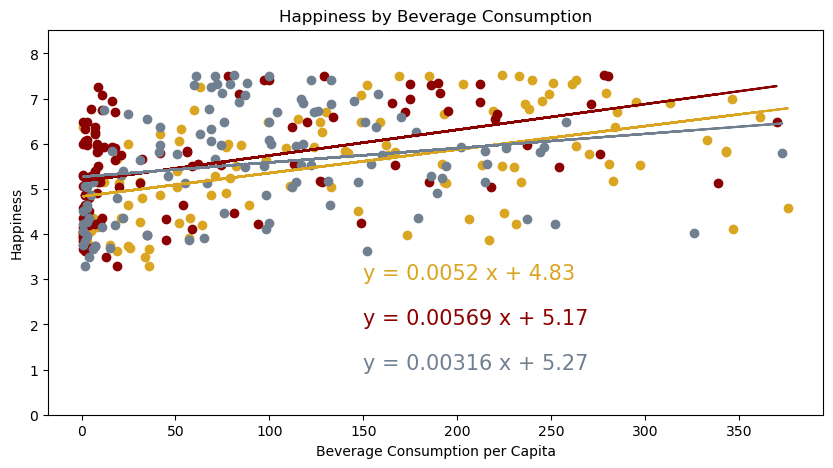

In [404]:

plt.figure(figsize=(10, 5))
beer_scat = lin_regress(OH_happiness["Beer_PerCapita"], OH_happiness["HappinessScore"], "goldenrod", 150, 3)
wine_scat = lin_regress(OH_happiness["Wine_PerCapita"], OH_happiness["HappinessScore"], "darkred", 150, 2)
spirit_scat = lin_regress(OH_happiness["Spirit_PerCapita"], OH_happiness["HappinessScore"], "slategray", 150, 1)

plt.show()

The None r-value is: 0.5308587177581222


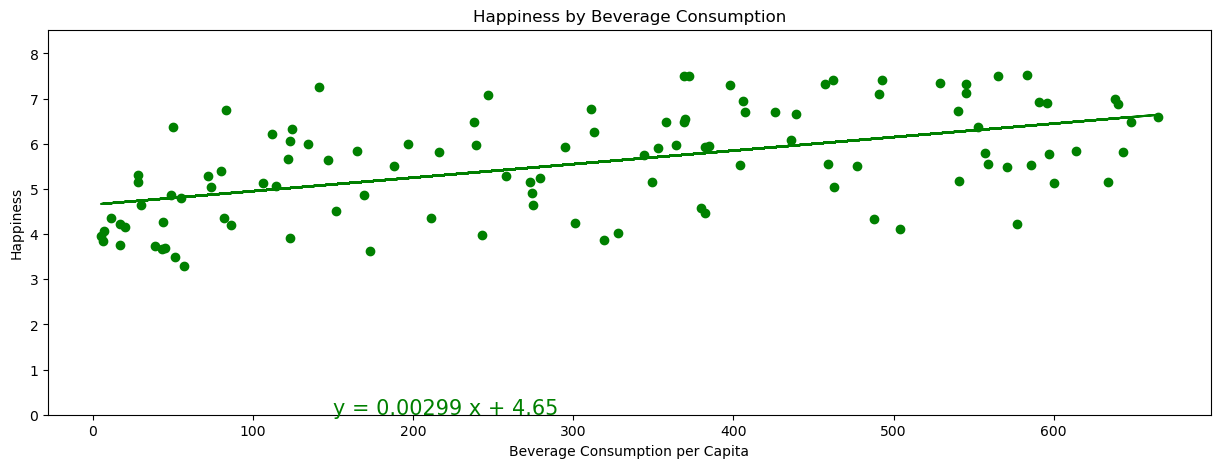

In [405]:
plt.figure(figsize=(15, 5))

all_bevs_scat = lin_regress(
    (OH_happiness["Beer_PerCapita"]+OH_happiness["Wine_PerCapita"]+OH_happiness["Spirit_PerCapita"]),
    OH_happiness["HappinessScore"], "green", 150, 0)